### 문제 1.
- 다음과 같은 prepare_data 함수를 이용하여 생성되는 가상의 학습표본 집합에 대해 학습을 한 후 결과를 시각화할 수 있도록 1.3.2항의 실습 프로그램을 수정하고, 그 결과를 고찰하라

### 문제 1. 코드(1) 필요한 패키지 불러오기
- 데이터 시각화를 위해 matplotlib.pyplot을 사용
- 배열 및 수학 계산을 위해 numpy를 사용
- 붓꽃 데이터 집합 데이터 대신 문제에서 제시된 가상의 데이터셋을 활용

In [235]:
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.datasets import load_iris

### 문제1. 코드(2) 데이터 준비 함수 정의하기
- 문제 1번에 제시된 prepare_data 함수를 이용하여 가상의 학습표본을 생성
- 시드를 고정하여 무작위로 생성되는 데이터를 고정시킬 수 있도록 코드 추가 (결과 재현성 등을 고려)

In [236]:
def prepare_data(N):
    # N : 학습표본의 수
    # 클래스 0의 평균 좌표 : (1, 2)
    # 클래스 1의 평균 좌표 : (2, 1)
    C = np.array([[1, 2], [2, 1]])
    X = []
    y = []
    
    # 시드고정
    seed = 99                               
    rnd = np.random.default_rng(seed)
    
    # 시드고정 안하는 경우 -> X, y 값이 실행할때마다 계속 변함
    # rnd = np.random.default_rng()
            
    # 각 클래스 평균 좌표에 무작위 값을 더하여 학습표본 집합 생성
    for i in range(N):
        j = rnd.integers(0, 2)
        x = np.array(rnd.normal(loc = 0.0, scale = 0.2, size = 2)) + C[j]
        X.append(x)
        y.append(j)
    return np.array(X), np.array(y), ['0', '1']

# prepare_data(10)                 # 출력결과 확인용

### 문제1. 코드(3) 활성함수 - 단위 계단 함수

In [237]:
# 활성 함수 - 단위 계단 함수
def step(x):
    return int(x >= 0)

### 문제1. 코드(4) 퍼셉트론 객체를 만들기 위한 클래스 선언하기
- __init__(self, dim, activation): 퍼셉트론 객체를 초기화한다. 연결 가중치 w와 바이어스 b는 정규분포 랜덤 값으로 초기화
- printW(self): 퍼셉트론 객체의 연결 가중치 및 바이어스를 출력한다.
- predict(self, x): 학습된 퍼셉트론 객체가 입력된 표본 배열 x로부터 출력을 계산하여 반환한다.
- fit(self, X, y, N, ephocs, eta=0.01): 주어진 학습표본 집합을 이용하여 퍼셉트론 객체를 훈련한다. X는 특징, y는 레이블을 저장하는 numpy 배열, N은 표본의 수, epochs는 반복 횟수, eta는 학습률이다.

함수에서 처리하는 내용은 다음과 같다.

- 21 ~ 24행: 학습표본이 무작위 순서로 사용되게 섞는다.
- 29 ~ 40행: 지정된 횟수만큼 전체 학습표본에 대해 반복 학습한다.
- 32행: 클래스의 predict 함수를 사용하여 식(1-14)의 출력을 계산한 후 레이블과의 오차 δ를 구한다.   
- 33~34행: 식(1-15)에 따라 연결 가중치 w와 바이어스 b를 업데이트한다.
<img src="%EC%88%98%EC%8B%9D%281-1415%29.png" width=500px alt="수식 1-14, 1-15"></img>

#### Numpy의 랜덤함수
▲ np.random.normal() => 정규분포(normal distribution)를 고려한 랜덤한수의 배열 생성
```Python
np.random.normal(0, 1, (3,3)) # 평균=0, 표준편차=1, 3x3 배열
```

▲ np.random.rand() => 균등분포(uniform distribution)를 고려한 랜덤한 수의 배열 생성
```Python
np.random.rand(3,3) #3x3 배열
```

▲ np.random.randn() => 표준정규분포(standard normal distribution)를 고려한 랜덤한 수의 배열 생성
```Python
np.random.randn(3,3) #3x3 배열
```

In [238]:
class Perceptron():
    def __init__(self, dim, activation):
        rnd = np.random.default_rng()
        self.dim = dim                         # 입력층 입력의 수(특징 개수 -> 2개)
        self.activation = activation
        # 가중치(w)와 바이어스(b)를 He normal 방식으로 초기화
        self.w = rnd.normal(scale = np.sqrt(2.0 / dim), size=dim)
        self.b = rnd.normal(scale = np.sqrt(2.0 / dim))

    def printW(self):
        for i in range(self.dim):
            print('  w{} = {:6.3f}'.format(i+1, self.w[i]), end='')
        print('  b = {:6.3f}'.format(self.b))

    def predict(self, x):  # numpy 배열 x에 저장된 표본의 출력 계산
        return np.array([self.activation(np.dot(self.w, x[i]) + self.b)
                          for i in range(len(x))])

    def fit(self, X, y, N, epochs, eta=0.01):
        # 학습표본의 인덱스를 무작위 순서로 섞음
        idx = list(range(N))
        np.random.shuffle(idx)
        X = np.array([X[idx[i]] for i in range(N)])
        y = np.array([y[idx[i]] for i in range(N)])

        f = 'Epochs = {:4d}    Loss = {:8.5f}'
        print('w의 초깃값  ', end='')
        self.printW()
        for j in range(epochs):
            for i in range(N):
                # x[i]에 대한 출력 오차 계산
                delta = self.predict([X[i]])[0] - y[i]
                self.w -= eta * delta * X[i] #가중치 w 업데이트
                self.b -= eta * delta        #바이어스 b 업데이트
            # 학습 과정 출력
            if j < 10 or (j+1) % 100 == 0:
                loss = self.predict(X) - y
                loss = (loss * loss).sum() / N #MSE 평균 제곱 오차 계산
                print(f.format(j+1, loss), end='')
                self.printW()

### 문제1. 코드(5) 모델 시각화
학습된 신경망의 동작을 시각화하는 함수를 정의한다.
- net: 학습된 퍼셉트론(신경망)
- X, y: 학습표본 집합의 입력 및 출력/특징 및 레이블의 배열
- multi_class: 3개 이상의 클래를 대상으로 분류하는 신경망인 경우 참(Tru)임.
- labels: 산점도를 그릴 클래스 레이블 리스트
- class_id: 클래스의 이름으로 출력할 스트링 리스트
- colors: 클래스를 구분할 색상 리스트
- xlabel, ylabel: x, y축에 표시할 레이블
- legend_loc: 범례를 표시할 위치

함수에서 처리하는 내용은 다음과 같다.
- 3 ~ 14행: 데이터 범위의 격자 좌표의 배열을 구한다.
- 16 ~ 23행: 학습된 퍼셉트론 객체로 3~14행에서 구한 좌표에 대한 출력을 구한다.
- 25 ~ 43행: pyplot을 이용하여 학습표본(큰 점으로 출력함)과 함께 격자 좌표 배열에 대한 신경망의 식별 결과(작은 점으로 출력)의 산점도를 그린다.

In [239]:
def visualize(net, X, y, multi_class, labels, class_id, colors,xlabel, ylabel, legend_loc='lower right'):
    # 데이터의 최소~최대 범위를 0.05 간격의 좌표값으로 나열
    x_max = np.ceil(np.max(X[:, 0])).astype(int)
    x_min = np.floor(np.min(X[:, 0])).astype(int)
    y_max = np.ceil(np.max(X[:, 1])).astype(int)
    y_min = np.floor(np.min(X[:, 1])).astype(int)
    x_lin = np.linspace(x_min, x_max, (x_max-x_min)*20+1)
    y_lin = np.linspace(y_min, y_max, (y_max-y_min)*20+1)

    # x_lin과 y_lin의 격자좌표의 x와 y 값 구하기
    x_mesh, y_mesh = np.meshgrid(x_lin, y_lin)

    # (x, y) 좌표의 배열로 만들어 신경망의 입력 구성
    X_test = np.column_stack([x_mesh.ravel(), y_mesh.ravel()])

    # 학습된 신경망으로 X_test에 대한 출력 계산
    if multi_class:
        y_hat = net.predict(X_test)
        y_hat = np.array([np.argmax(y_hat[k])
                            for k in range(len(y_hat))], dtype=int)
    else:
        y_hat = (net.predict(X_test) >= 0.5).astype(int)
        y_hat = y_hat.reshape(len(y_hat))

    # 출력할 그래프의 수평/수직 범위 설정
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # 클래스별로 산점도 그리기
    for c, i, c_name in zip(colors, labels, class_id):
        # 격자 좌표의 클래스별 산점도
        plt.scatter(X_test[y_hat == i, 0], X_test[y_hat == i, 1],
                     c = c, s = 5, alpha = 0.3, edgecolors = 'none')
        # 학습 표본의 클래스별 산점도
        plt.scatter(X[y == i, 0], X[y == i, 1],
                     c = c, s = 20, label=c_name)
    # 범례의 표시 위치 지정
    plt.legend(loc=legend_loc)
    
    # x축과 y축의 레이블을 지정한 후 그래프 출력
    plt.xlabel(xlabel, size=12)
    plt.ylabel(ylabel, size=12)
    plt.show()

### 문제1. 코드(6) 훈련 데이터 준비하기
prepare_data 함수를 이용하여 150개의 무작위 생성 2차원 데이터를 numpy 배열 형태로 X에 저장한다.
- y에 0 또는 1 무작위 생성 데이터를 저장

In [240]:
nSamples = 150
nDim = 2                                          # 생성된 데이터는 2차원
# target = 'setosa'                               # 바뀐 데이터에서는 필요 없음
X, y, labels = prepare_data(nSamples)             # prepare_data() 함수의 인자 변경해줌

### 문제1. 코드(7) 퍼셉트론 객체 생성 및 학습
활성함수를 단위 계단 함수로 설정하여 2차원 입력으로 구성되는 퍼셉트론 객체를 생성한다.
- 전체 학습표본에 대해 1,000번 반복하여 학습하며, 학습률은 0.01로 지정한다.

#### <epochs 설명>
한 번의 epoch는 인공 신경망에서 전체 데이터 셋에 대해 forward pass/backward pass 과정을 거친 것을 말한다.
- 즉, 전체 데이터 셋에 대해 한 번 학습을 완료한 상태를 의미한다.

▶ 신경망에서 사용되는 역전파 알고리즘(backpropagation algorithm)은 파라미터를 사용하여 입력부터 출력까지의 각 계층의 weight를 계산하는 과정을 거치는 순방향 패스(forward pass)과 forward pass를 반대로 거슬러 올라가며 다시 한 번 계산 과정을 거처 기존의 weight를 수정하는 역방향 패스(backward pass)로 나뉜다. 
- 이 전체 데이터 셋에 대해 해당 과정(forward pass + backward pass)이 완료되면 한 번의 epoch가 진행됐다고 볼 수 있다.
- 따라서 epochs = 1000 이라면 전체 데이터를 1000번 사용해서 학습을 거치는 것이다.

In [241]:
p = Perceptron(nDim, activation=step)
p.fit(X, y, nSamples, epochs=1000, eta=0.01)

w의 초깃값    w1 = -0.889  w2 =  0.291  b =  0.637
Epochs =    1    Loss =  0.36667  w1 = -0.143  w2 = -0.241  b =  0.687
Epochs =    2    Loss =  0.06667  w1 = -0.075  w2 = -0.328  b =  0.657
Epochs =    3    Loss =  0.03333  w1 = -0.060  w2 = -0.350  b =  0.647
Epochs =    4    Loss =  0.06000  w1 = -0.029  w2 = -0.355  b =  0.647
Epochs =    5    Loss =  0.02667  w1 = -0.020  w2 = -0.375  b =  0.637
Epochs =    6    Loss =  0.03333  w1 = -0.002  w2 = -0.377  b =  0.637
Epochs =    7    Loss =  0.02000  w1 = -0.006  w2 = -0.394  b =  0.627
Epochs =    8    Loss =  0.02000  w1 =  0.012  w2 = -0.395  b =  0.627
Epochs =    9    Loss =  0.00667  w1 =  0.008  w2 = -0.410  b =  0.617
Epochs =   10    Loss =  0.00667  w1 =  0.016  w2 = -0.410  b =  0.617
Epochs =  100    Loss =  0.00000  w1 =  0.162  w2 = -0.508  b =  0.507
Epochs =  200    Loss =  0.00000  w1 =  0.162  w2 = -0.508  b =  0.507
Epochs =  300    Loss =  0.00000  w1 =  0.162  w2 = -0.508  b =  0.507
Epochs =  400    Loss =  0.000

### 문제1. 코드(8) 특징 공간 결정 영역 시각화
무작위 생성된 데이터가 학습된 퍼셉트론에 의해 어떻게 분할되는지 그래프로 보여준다.

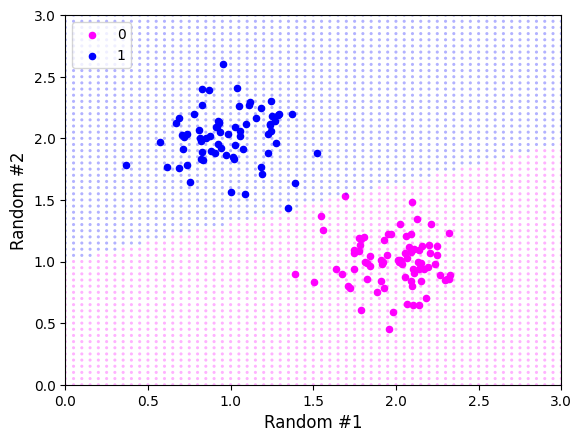

In [242]:
# 학습표본의 순서를 섞거나 연결 가중치 및 바이어스 초깃값을 정할 때 무작위 수를 이용하고 있으며, 이에 따른 학습 결과는 일정하지 않다.
visualize(p, X, y,
          multi_class = False,
          class_id = labels,
          labels = [1, 0],
          colors = ['magenta', 'blue'],
          xlabel = 'Random #1',
          ylabel = 'Random #2',
          legend_loc = 'upper left')

### 결론
- 단층 퍼셉트론은 기본적으로 선형 분리 가능한 문제(linearly separable)만 정확하게 분류할 수 있다.
- 이 문제의 경우 prepare_data에서 생성된 데이터는 클래스 0, 1이 각각 다른 좌표의 중심을 가지는 분포이며 --> 이는 선형 분리가 가능한 형태이다.
- 다만 퍼셉트론에서 활성함수로 사용되는 단위 계단 함수는 일반화 오류의 원인이 될 수 있다.
- 일반화 오류 : 학습 도중 두 클래스를 나눌 수 있는 경계가 찾아지기만 하면 모든 학습표본에 대해 교재 식(1-15)의 델타 값이 0이 되어 더 이상 가중치가 업데이트 되지 않는다.
- 이로 인해 학습의 결과 선형경계선이 다양하게 나타나게 된다. --> 이러한 경계는 새로운 표본에 대해서는 오류가 발생할 가능성이 크다.
- 학습표본의 순서를 섞거나 연결 가중치 및 바이어스 초깃값을 정할 때 무작위 수를 이용하고 있으며, 이에 따른 학습 결과는 일정하지 않다.

### 문제 2.
- 다음과 같은 prepare_data 함수를 이용하여 생성되는 가상의 학습표본 집합에 대해 학습을 한 후 결과를 시각화할 수 있도록 1.3.2항의 실습 프로그램을 수정하고, 그 결과를 고찰하라

### 문제 2. 코드(1) 필요한 패키지 불러오기
- 데이터 시각화를 위해 matplotlib.pyplot을 사용
- 배열 및 수학 계산을 위해 numpy를 사용
- 붓꽃 데이터 집합 데이터 대신 문제에서 제시된 가상의 데이터셋을 활용

In [243]:
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.datasets import load_iris

### 문제2. 코드(2) 데이터 준비 함수 정의하기
- 문제 2번에 제시된 prepare_data 함수를 이용하여 가상의 학습표본을 생성
- 시드를 고정하여 무작위로 생성되는 데이터를 고정시킬 수 있도록 코드 추가 (결과 재현성 등을 고려)

In [244]:
def prepare_data(N):
    # N : 학습표본의 수
    # 클래스 0의 평균 좌표 : (1, 2), (2, 1)
    # 클래스 1의 평균 좌표 : (1, 1), (2, 2)
    C = np.array([[1, 2], [2, 1], [1, 1], [2, 2]])
    X = []
    y = []
    
    # 시드고정
    seed = 99                               
    rnd = np.random.default_rng(seed)
    
    # 시드고정 안하는 경우 -> X, y 값이 실행할때마다 계속 변함
    # rnd = np.random.default_rng()
            
    # 각 클래스 평균 좌표에 무작위 값을 더하여 학습표본 집합 생성
    for i in range(N):
        j = rnd.integers(0, 4)
        x = np.array(rnd.normal(loc = 0.0, scale = 0.2, size = 2)) + C[j]
        X.append(x)
        y.append(j // 2)
    return np.array(X), np.array(y), ['0', '1']

prepare_data(10)                           # 출력 결과 확인용

(array([[1.90711632, 2.01010301],
        [1.13724616, 0.6486419 ],
        [1.90843143, 0.88071598],
        [0.79060649, 1.1863584 ],
        [2.24888824, 1.17861748],
        [2.05260099, 2.06570357],
        [1.8244774 , 1.99082078],
        [2.07637435, 0.90949221],
        [0.92956732, 2.1345594 ],
        [2.02812466, 1.09251214]]),
 array([1, 1, 0, 1, 0, 1, 1, 0, 0, 0], dtype=int64),
 ['0', '1'])

### 문제2. 코드(3) 활성함수 - 단위 계단 함수

In [245]:
# 활성 함수 - 단위 계단 함수
def step(x):
    return int(x >= 0)

### 문제2. 코드(4) 퍼셉트론 객체를 만들기 위한 클래스 선언하기
- __init__(self, dim, activation): 퍼셉트론 객체를 초기화한다. 연결 가중치 w와 바이어스 b는 정규분포 랜덤 값으로 초기화
- printW(self): 퍼셉트론 객체의 연결 가중치 및 바이어스를 출력한다.
- predict(self, x): 학습된 퍼셉트론 객체가 입력된 표본 배열 x로부터 출력을 계산하여 반환한다.
- fit(self, X, y, N, ephocs, eta=0.01): 주어진 학습표본 집합을 이용하여 퍼셉트론 객체를 훈련한다. X는 특징, y는 레이블을 저장하는 numpy 배열, N은 표본의 수, epochs는 반복 횟수, eta는 학습률이다.

함수에서 처리하는 내용은 다음과 같다.

- 21 ~ 24행: 학습표본이 무작위 순서로 사용되게 섞는다.
- 29 ~ 40행: 지정된 횟수만큼 전체 학습표본에 대해 반복 학습한다.
- 32행: 클래스의 predict 함수를 사용하여 식(1-14)의 출력을 계산한 후 레이블과의 오차 δ를 구한다.   
- 33~34행: 식(1-15)에 따라 연결 가중치 w와 바이어스 b를 업데이트한다.
<img src="%EC%88%98%EC%8B%9D%281-1415%29.png" width=500px alt="수식 1-14, 1-15"></img>

In [246]:
class Perceptron():
    def __init__(self, dim, activation):
        rnd = np.random.default_rng()
        self.dim = dim                         # 입력층 입력의 수(특징 개수 -> 2개)
        self.activation = activation
        # 가중치(w)와 바이어스(b)를 He normal 방식으로 초기화
        self.w = rnd.normal(scale = np.sqrt(2.0 / dim), size=dim)
        self.b = rnd.normal(scale = np.sqrt(2.0 / dim))

    def printW(self):
        for i in range(self.dim):
            print('  w{} = {:6.3f}'.format(i+1, self.w[i]), end='')
        print('  b = {:6.3f}'.format(self.b))

    def predict(self, x):  # numpy 배열 x에 저장된 표본의 출력 계산
        return np.array([self.activation(np.dot(self.w, x[i]) + self.b)
                          for i in range(len(x))])

    def fit(self, X, y, N, epochs, eta=0.01):
        # 학습표본의 인덱스를 무작위 순서로 섞음
        idx = list(range(N))
        np.random.shuffle(idx)
        X = np.array([X[idx[i]] for i in range(N)])
        y = np.array([y[idx[i]] for i in range(N)])

        f = 'Epochs = {:4d}    Loss = {:8.5f}'
        print('w의 초깃값  ', end='')
        self.printW()
        for j in range(epochs):
            for i in range(N):
                # x[i]에 대한 출력 오차 계산
                delta = self.predict([X[i]])[0] - y[i]
                self.w -= eta * delta * X[i] #가중치 w 업데이트
                self.b -= eta * delta        #바이어스 b 업데이트
            # 학습 과정 출력
            if j < 10 or (j+1) % 100 == 0:
                loss = self.predict(X) - y
                loss = (loss * loss).sum() / N #MSE 평균 제곱 오차 계산
                print(f.format(j+1, loss), end='')
                self.printW()

### 문제2. 코드(5) 모델 시각화
학습된 신경망의 동작을 시각화하는 함수를 정의한다.
- net: 학습된 퍼셉트론(신경망)
- X, y: 학습표본 집합의 입력 및 출력/특징 및 레이블의 배열
- multi_class: 3개 이상의 클래를 대상으로 분류하는 신경망인 경우 참(Tru)임.
- labels: 산점도를 그릴 클래스 레이블 리스트
- class_id: 클래스의 이름으로 출력할 스트링 리스트
- colors: 클래스를 구분할 색상 리스트
- xlabel, ylabel: x, y축에 표시할 레이블
- legend_loc: 범례를 표시할 위치

함수에서 처리하는 내용은 다음과 같다.
- 3 ~ 14행: 데이터 범위의 격자 좌표의 배열을 구한다.
- 16 ~ 23행: 학습된 퍼셉트론 객체로 3~14행에서 구한 좌표에 대한 출력을 구한다.
- 25 ~ 43행: pyplot을 이용하여 학습표본(큰 점으로 출력함)과 함께 격자 좌표 배열에 대한 신경망의 식별 결과(작은 점으로 출력)의 산점도를 그린다.

In [247]:
def visualize(net, X, y, multi_class, labels, class_id, colors,xlabel, ylabel, legend_loc='lower right'):
    # 데이터의 최소~최대 범위를 0.05 간격의 좌표값으로 나열
    x_max = np.ceil(np.max(X[:, 0])).astype(int)
    x_min = np.floor(np.min(X[:, 0])).astype(int)
    y_max = np.ceil(np.max(X[:, 1])).astype(int)
    y_min = np.floor(np.min(X[:, 1])).astype(int)
    x_lin = np.linspace(x_min, x_max, (x_max-x_min)*20+1)
    y_lin = np.linspace(y_min, y_max, (y_max-y_min)*20+1)

    # x_lin과 y_lin의 격자좌표의 x와 y 값 구하기
    x_mesh, y_mesh = np.meshgrid(x_lin, y_lin)

    # (x, y) 좌표의 배열로 만들어 신경망의 입력 구성
    X_test = np.column_stack([x_mesh.ravel(), y_mesh.ravel()])

    # 학습된 신경망으로 X_test에 대한 출력 계산
    if multi_class:
        y_hat = net.predict(X_test)
        y_hat = np.array([np.argmax(y_hat[k])
                            for k in range(len(y_hat))], dtype=int)
    else:
        y_hat = (net.predict(X_test) >= 0.5).astype(int)
        y_hat = y_hat.reshape(len(y_hat))

    # 출력할 그래프의 수평/수직 범위 설정
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # 클래스별로 산점도 그리기
    for c, i, c_name in zip(colors, labels, class_id):
        # 격자 좌표의 클래스별 산점도
        plt.scatter(X_test[y_hat == i, 0], X_test[y_hat == i, 1],
                     c = c, s = 5, alpha = 0.3, edgecolors = 'none')
        # 학습 표본의 클래스별 산점도
        plt.scatter(X[y == i, 0], X[y == i, 1],
                     c = c, s = 20, label=c_name)
    # 범례의 표시 위치 지정
    plt.legend(loc=legend_loc)
    
    # x축과 y축의 레이블을 지정한 후 그래프 출력
    plt.xlabel(xlabel, size=12)
    plt.ylabel(ylabel, size=12)
    plt.show()

### 문제2. 코드(6) 훈련 데이터 준비하기
prepare_data 함수를 이용하여 150개의 무작위 생성 2차원 데이터를 numpy 배열 형태로 X에 저장한다.
- y에 0 또는 1 무작위 생성 데이터를 저장

In [248]:
nSamples = 150
nDim = 2                                          # 생성된 데이터는 2차원
# target = 'setosa'                               # 바뀐 데이터에서는 필요 없음
X, y, labels = prepare_data(nSamples)             # prepare_data() 함수의 인자 변경해줌

### 문제2. 코드(7) 퍼셉트론 객체 생성 및 학습
활성함수를 단위 계단 함수로 설정하여 2차원 입력으로 구성되는 퍼셉트론 객체를 생성한다.
- 전체 학습표본에 대해 1,000번 반복하여 학습하며, 학습률은 0.01로 지정한다.

In [249]:
p = Perceptron(nDim, activation=step)
p.fit(X, y, nSamples, epochs=1000, eta=0.01)

w의 초깃값    w1 = -1.815  w2 = -1.240  b = -1.342
Epochs =    1    Loss =  0.53333  w1 = -0.613  w2 = -0.032  b = -0.542
Epochs =    2    Loss =  0.42667  w1 = -0.110  w2 =  0.265  b = -0.222
Epochs =    3    Loss =  0.43333  w1 = -0.014  w2 =  0.116  b = -0.142
Epochs =    4    Loss =  0.50000  w1 =  0.011  w2 =  0.050  b = -0.082
Epochs =    5    Loss =  0.44000  w1 =  0.002  w2 =  0.025  b = -0.042
Epochs =    6    Loss =  0.38667  w1 = -0.007  w2 =  0.025  b = -0.022
Epochs =    7    Loss =  0.60000  w1 = -0.016  w2 =  0.013  b = -0.012
Epochs =    8    Loss =  0.53333  w1 = -0.011  w2 =  0.001  b = -0.012
Epochs =    9    Loss =  0.22000  w1 = -0.011  w2 =  0.017  b = -0.002
Epochs =   10    Loss =  0.58000  w1 = -0.022  w2 =  0.010  b = -0.002
Epochs =  100    Loss =  0.20000  w1 = -0.014  w2 =  0.014  b =  0.008
Epochs =  200    Loss =  0.53333  w1 = -0.016  w2 = -0.000  b = -0.002
Epochs =  300    Loss =  0.20000  w1 = -0.012  w2 =  0.011  b =  0.008
Epochs =  400    Loss =  0.533

### 문제2. 코드(8) 특징 공간 결정 영역 시각화
무작위 생성된 데이터가 학습된 퍼셉트론에 의해 어떻게 분할되는지 그래프로 보여준다.

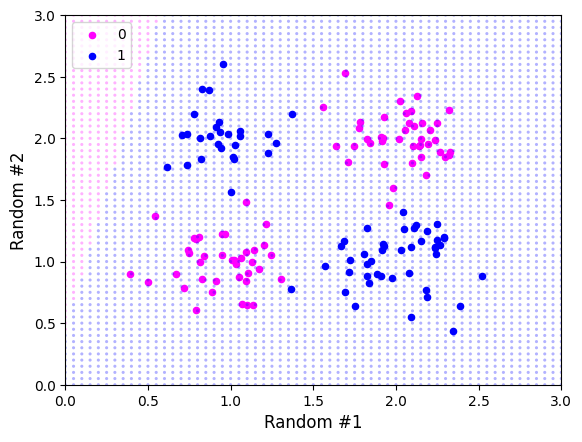

In [250]:
# 학습표본의 순서를 섞거나 연결 가중치 및 바이어스 초깃값을 정할 때 무작위 수를 이용하고 있으며, 이에 따른 학습 결과는 일정하지 않다.
visualize(p, X, y,
          multi_class = False,
          class_id = labels,
          labels = [1, 0],
          colors = ['magenta', 'blue'],
          xlabel = 'Random #1',
          ylabel = 'Random #2',
          legend_loc = 'upper left')

### 결론
- 단층 퍼셉트론은 기본적으로 선형 분리 가능한 문제(linearly separable)만 정확하게 분류할 수 있다.
- 이 문제의 경우 prepare_data에서 생성된 데이터는 클래스 0, 1이 두 개씩 중심을 가지는 분포이며 --> 이는 완전히 선형 분리가 어렵다.
- 학습 결과를 보면, 가능한 한 직선으로 경계를 그으려 하지만 완벽하게 클래스 분리를 할 수 없다는 것을 알 수 있다.
- 마찬가지로 학습표본의 순서를 섞거나 연결 가중치 및 바이어스 초깃값을 정할 때 무작위 수를 이용하고 있으며, 이에 따른 학습 결과는 일정하지 않다.